In [3]:
# =========================
# Cell 1: Imports, config, load data
# =========================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

# Optional libraries (only used if installed)
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False

try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False

TSNE_AVAILABLE = False
UMAP_AVAILABLE = False
try:
    from openTSNE import TSNE
    TSNE_AVAILABLE = True
except ImportError:
    pass

try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    pass

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# -------- Load dataset --------
DATA_PATH = "MentalHealthSurvey.csv"  # change if your filename is different

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"Could not find {DATA_PATH}. Put the CSV next to this notebook or update DATA_PATH."
    )

df = pd.read_csv(DATA_PATH)

print("=== Basic dataset info ===")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nHead:")
print(df.head())

print("\n=== Missing values per column ===")
print(df.isna().sum())


=== Basic dataset info ===
Shape: (87, 21)
Columns: ['gender', 'age', 'university', 'degree_level', 'degree_major', 'academic_year', 'cgpa', 'residential_status', 'campus_discrimination', 'sports_engagement', 'average_sleep', 'study_satisfaction', 'academic_workload ', 'academic_pressure', 'financial_concerns', 'social_relationships', 'depression', 'anxiety', 'isolation', 'future_insecurity', 'stress_relief_activities']

Head:
   gender  age university   degree_level      degree_major academic_year  \
0    Male   20         PU  Undergraduate      Data Science      2nd year   
1    Male   20        UET   Postgraduate  Computer Science      3rd year   
2    Male   20       FAST  Undergraduate  Computer Science      3rd year   
3    Male   20        UET  Undergraduate  Computer Science      3rd year   
4  Female   20        UET  Undergraduate  Computer Science      3rd year   

      cgpa residential_status campus_discrimination sports_engagement  ...  \
0  3.0-3.5         Off-Campus     

=== Descriptive statistics (numeric) ===
             age  study_satisfaction  academic_workload   academic_pressure  \
count  87.000000           87.000000           87.000000          87.000000   
mean   19.942529            3.931034            3.885057           3.781609   
std     1.623636            1.043174            0.854880           1.125035   
min    17.000000            1.000000            2.000000           1.000000   
25%    19.000000            3.000000            3.000000           3.000000   
50%    20.000000            4.000000            4.000000           4.000000   
75%    21.000000            5.000000            4.500000           5.000000   
max    26.000000            5.000000            5.000000           5.000000   

       financial_concerns  social_relationships  depression    anxiety  \
count           87.000000             87.000000   87.000000  87.000000   
mean             3.390805              2.781609    3.218391   3.218391   
std              1.400634

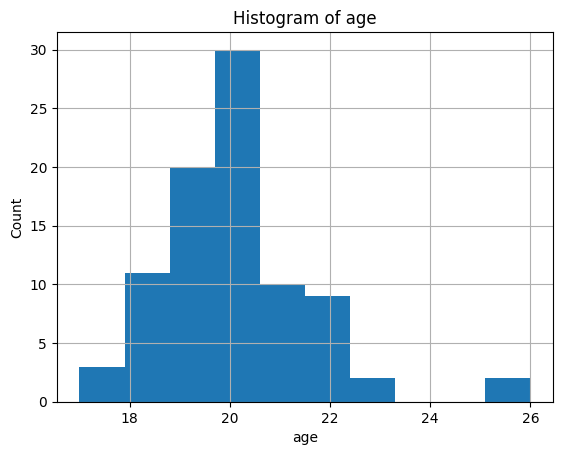

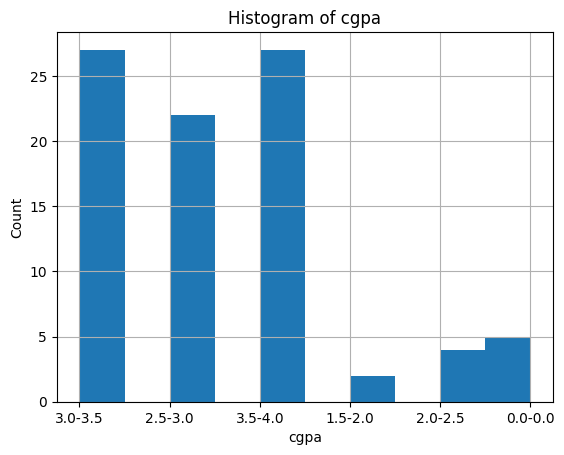

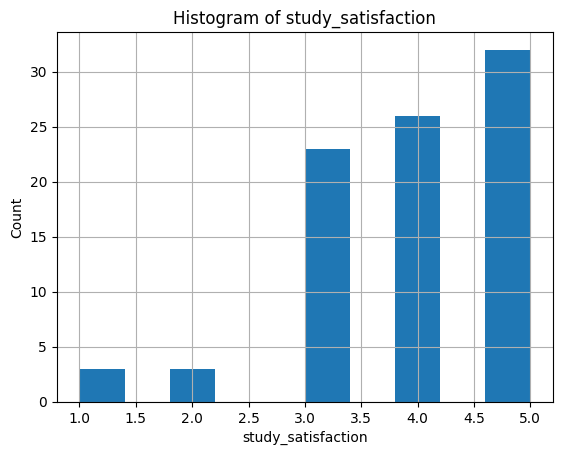

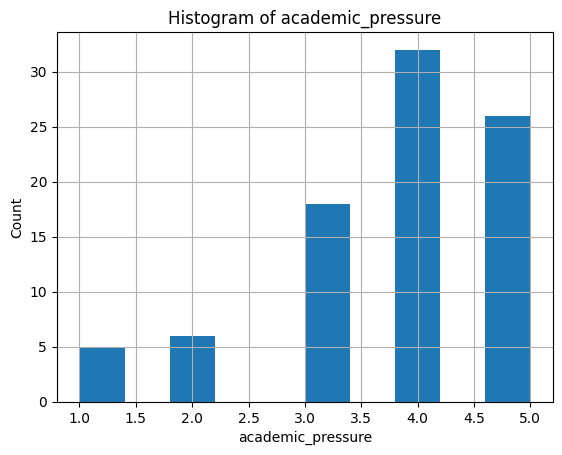

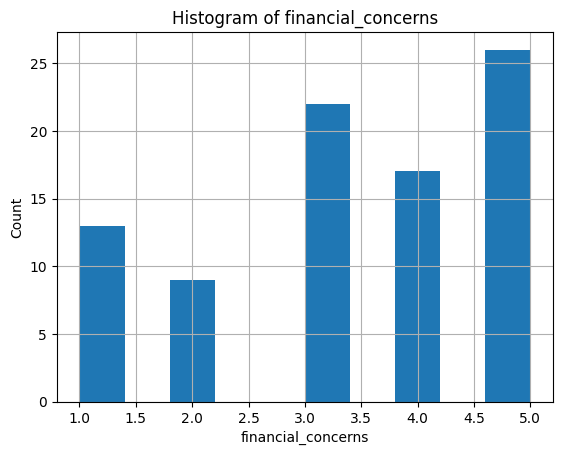

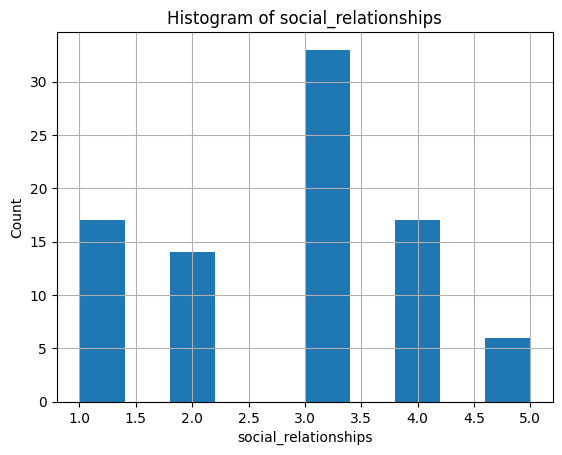

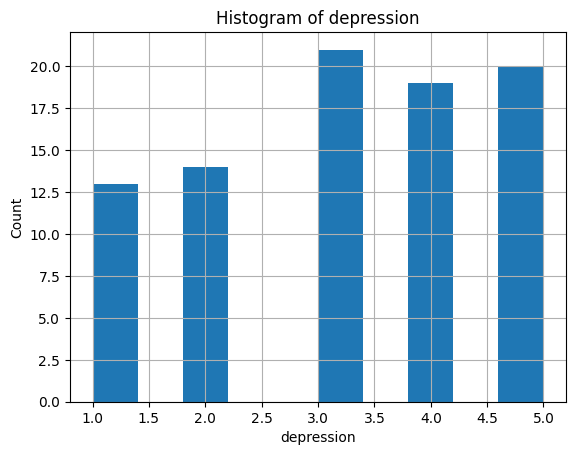

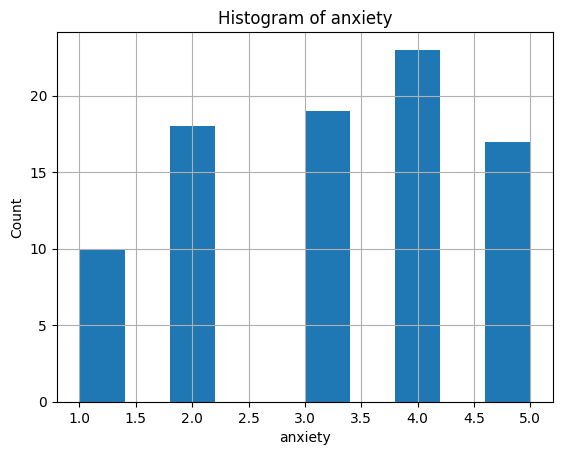

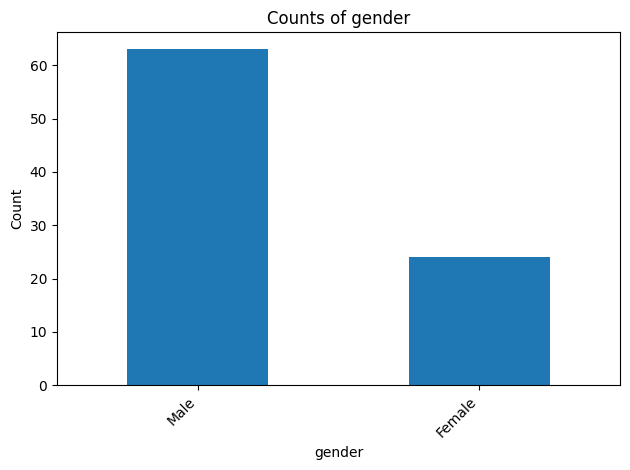

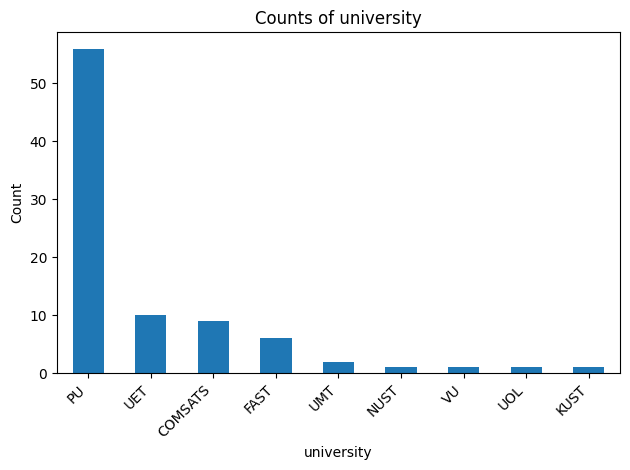

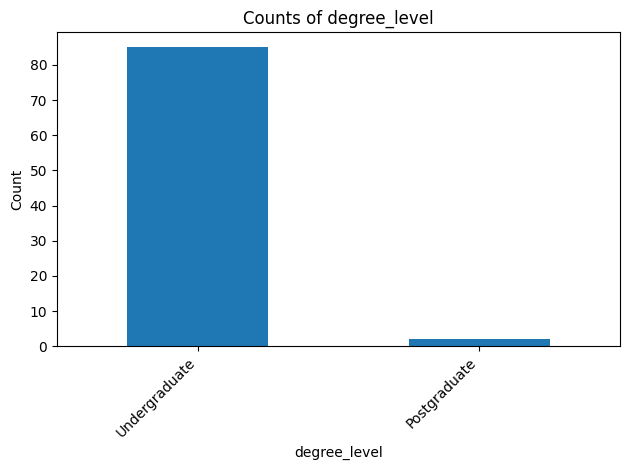

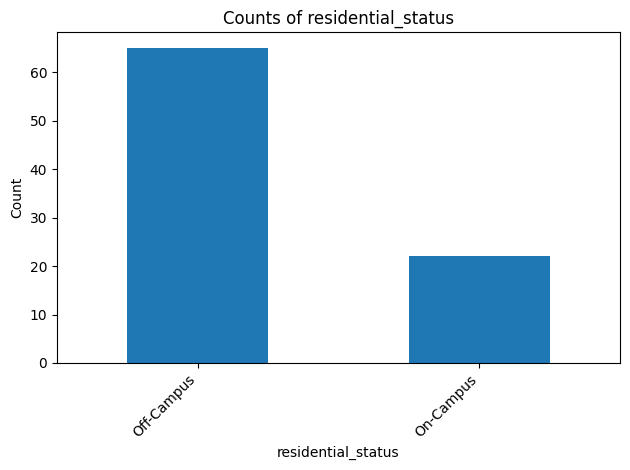

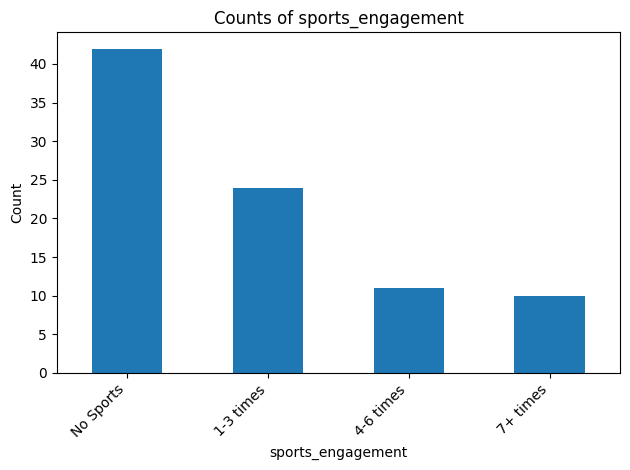

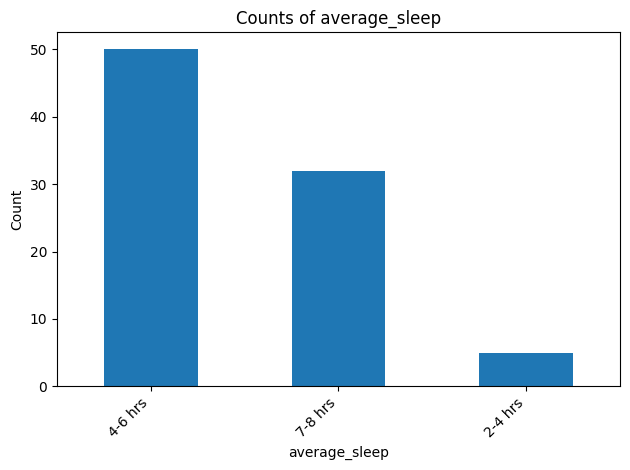

C:\Users\sishi\AppData\Local\Temp\ipykernel_1468\3366826211.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


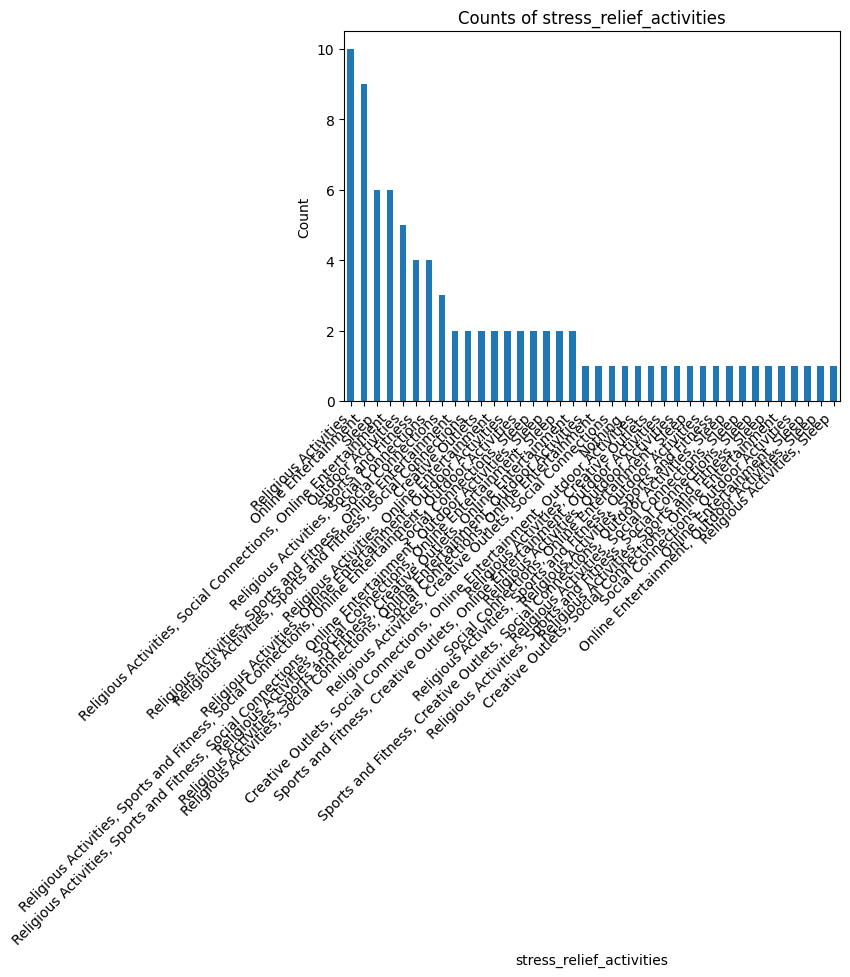

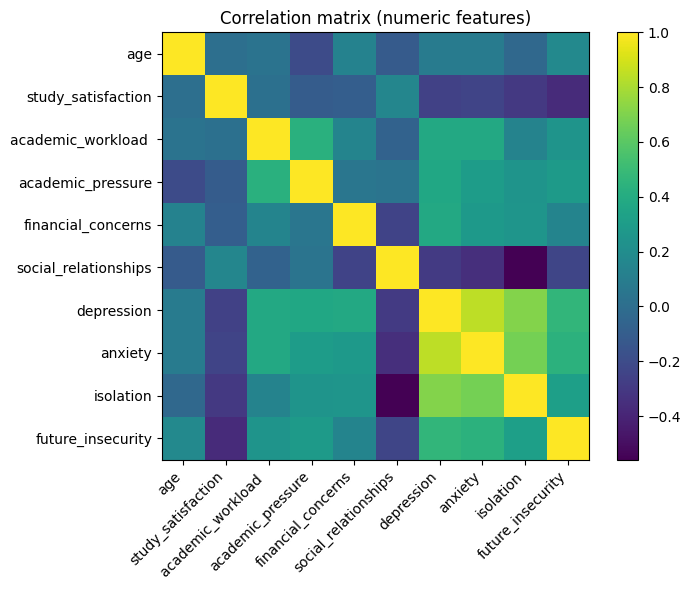


=== Correlation matrix ===
                           age  study_satisfaction  academic_workload   \
age                   1.000000            0.011363            0.037072   
study_satisfaction    0.011363            1.000000            0.017085   
academic_workload     0.037072            0.017085            1.000000   
academic_pressure    -0.204288           -0.102153            0.433020   
financial_concerns    0.132707           -0.092755            0.144775   
social_relationships -0.110217            0.158249           -0.071550   
depression            0.089504           -0.258286            0.379765   
anxiety               0.088800           -0.237822            0.379228   
isolation            -0.029515           -0.297775            0.139472   
future_insecurity     0.176095           -0.369635            0.246633   

                      academic_pressure  financial_concerns  \
age                           -0.204288            0.132707   
study_satisfaction            -

In [4]:
# =========================
# Cell 2: Basic EDA
# =========================

print("=== Descriptive statistics (numeric) ===")
print(df.describe(include=[np.number]))

print("\n=== Descriptive statistics (categorical) ===")
print(df.describe(include=["object"]))

# Helper plot functions
def plot_hist(column, bins=10):
    if column not in df.columns:
        return
    plt.figure()
    df[column].dropna().astype(float, errors="ignore").hist(bins=bins)
    plt.title(f"Histogram of {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.show()

def plot_bar(column):
    if column not in df.columns:
        return
    plt.figure()
    df[column].value_counts().plot(kind="bar")
    plt.title(f"Counts of {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Choose numeric/ordinal-looking columns from your dataset
num_like_cols = [
    "age", "cgpa", "study_satisfaction", "academic_workload",
    "academic_pressure", "financial_concerns", "social_relationships",
    "depression", "anxiety"
]
for col in num_like_cols:
    if col in df.columns:
        plot_hist(col)

cat_cols = [
    "gender", "university", "degree_level", "residential_status",
    "sports_engagement", "average_sleep", "stress_relief_activities"
]
for col in cat_cols:
    if col in df.columns:
        plot_bar(col)

# Correlation matrix for numeric columns
numeric_cols_raw = df.select_dtypes(include=[np.number]).columns.tolist()
if len(numeric_cols_raw) > 1:
    plt.figure(figsize=(8, 6))
    corr = df[numeric_cols_raw].corr()
    im = plt.imshow(corr, interpolation="nearest")
    plt.xticks(range(len(numeric_cols_raw)), numeric_cols_raw, rotation=45, ha="right")
    plt.yticks(range(len(numeric_cols_raw)), numeric_cols_raw)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Correlation matrix (numeric features)")
    plt.tight_layout()
    plt.show()
    print("\n=== Correlation matrix ===")
    print(corr)


In [5]:
# =========================
# Cell 3: Target & preprocessing (no sklearn)
# =========================

TARGET_COL = "depression"

if TARGET_COL not in df.columns:
    raise KeyError(f"Target column '{TARGET_COL}' not found in dataset.")

# Drop rows with missing target
df = df.dropna(subset=[TARGET_COL]).copy()

# Binary target: 0 = low/moderate (<=2) ; 1 = high (>=3)
def make_binary_target(x):
    try:
        x_float = float(x)
    except Exception:
        return np.nan
    return 1 if x_float >= 3 else 0

y = df[TARGET_COL].apply(make_binary_target)
df = df[~y.isna()].copy()
y = y[~y.isna()].astype(int).values  # numpy array

print("Target value counts (0=low/moderate, 1=high):")
unique, counts = np.unique(y, return_counts=True)
for u, c in zip(unique, counts):
    print(f"{u}: {c}")

# Features
X = df.drop(columns=[TARGET_COL])

# numeric vs categorical
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

print("\nNumeric features:", numeric_features)
print("Categorical features:", categorical_features)

# One-hot encode categoricals using pandas
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=False)

# Standardize all columns
X_values = X_encoded.values.astype(float)
feature_means = X_values.mean(axis=0)
feature_stds = X_values.std(axis=0) + 1e-6
X_scaled = (X_values - feature_means) / feature_stds

feature_names = X_encoded.columns.tolist()
print("\nEncoded feature matrix shape:", X_scaled.shape)


Target value counts (0=low/moderate, 1=high):
0: 27
1: 60

Numeric features: ['age', 'study_satisfaction', 'academic_workload ', 'academic_pressure', 'financial_concerns', 'social_relationships', 'anxiety', 'isolation', 'future_insecurity']
Categorical features: ['gender', 'university', 'degree_level', 'degree_major', 'academic_year', 'cgpa', 'residential_status', 'campus_discrimination', 'sports_engagement', 'average_sleep', 'stress_relief_activities']

Encoded feature matrix shape: (87, 85)


In [7]:
# =========================
# Cell 4: Train/test split & metric functions
# =========================

def train_test_split_manual(X, y, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    n_samples = X.shape[0]
    indices = np.random.permutation(n_samples)
    test_count = int(n_samples * test_size)
    test_idx = indices[:test_count]
    train_idx = indices[test_count:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

X_train, X_test, y_train, y_test = train_test_split_manual(
    X_scaled, y, test_size=0.2, random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# ---- metric functions (FIXED SHAPE ISSUE) ----
def classification_metrics(y_true, y_pred):
    # Convert everything to 1D int arrays
    y_true = np.array(y_true).astype(int).reshape(-1)
    y_pred = np.array(y_pred).astype(int).reshape(-1)

    assert y_true.shape == y_pred.shape

    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-8)
    precision = tp / (tp + fp + 1e-8) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn + 1e-8) if (tp + fn) > 0 else 0.0
    f1 = (2 * precision * recall / (precision + recall + 1e-8)
          if (precision + recall) > 0 else 0.0)

    cm = np.array([[tn, fp],
                   [fn, tp]])
    return accuracy, precision, recall, f1, cm

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# Convert to torch tensors for models
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32).view(-1, 1)

input_dim = X_train.shape[1]


Train shape: (70, 85) Test shape: (17, 85)


In [8]:
# =========================
# Cell 4: Train/test split & metric functions
# =========================

def train_test_split_manual(X, y, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    n_samples = X.shape[0]
    indices = np.random.permutation(n_samples)
    test_count = int(n_samples * test_size)
    test_idx = indices[:test_count]
    train_idx = indices[test_count:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

X_train, X_test, y_train, y_test = train_test_split_manual(
    X_scaled, y, test_size=0.2, random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# ---- metric functions (FIXED SHAPE ISSUE) ----
def classification_metrics(y_true, y_pred):
    # Convert everything to 1D int arrays
    y_true = np.array(y_true).astype(int).reshape(-1)
    y_pred = np.array(y_pred).astype(int).reshape(-1)

    assert y_true.shape == y_pred.shape

    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-8)
    precision = tp / (tp + fp + 1e-8) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn + 1e-8) if (tp + fn) > 0 else 0.0
    f1 = (2 * precision * recall / (precision + recall + 1e-8)
          if (precision + recall) > 0 else 0.0)

    cm = np.array([[tn, fp],
                   [fn, tp]])
    return accuracy, precision, recall, f1, cm

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# Convert to torch tensors for models
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32).view(-1, 1)

input_dim = X_train.shape[1]


Train shape: (70, 85) Test shape: (17, 85)


C:\Users\sishi\AppData\Local\Temp\ipykernel_1468\4047094025.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_true = np.array(y_true).astype(int).reshape(-1)


LogisticRegression Epoch 50/300, best F1 so far: 0.5714
LogisticRegression Epoch 100/300, best F1 so far: 0.5714
LogisticRegression Epoch 150/300, best F1 so far: 0.5714
LogisticRegression Epoch 200/300, best F1 so far: 0.5714
LogisticRegression Epoch 250/300, best F1 so far: 0.5714
LogisticRegression Epoch 300/300, best F1 so far: 0.5714

=== Logistic Regression performance ===
Accuracy : 0.470588235017301
Precision: 0.7499999990624999
Recall   : 0.46153846118343195
F1-score : 0.5714285661678005
Confusion matrix:
 [[2 2]
 [7 6]]


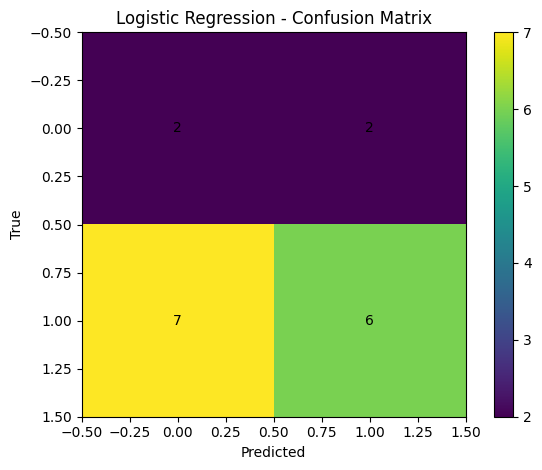

In [9]:
# =========================
# Cell 5: Logistic Regression (PyTorch)
# =========================

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)  # logits

def train_model(model, X_train, y_train, X_val, y_val,
                lr=1e-3, epochs=500, batch_size=16, weight_decay=0.0,
                verbose=False, model_name="model"):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    n_samples = X_train.shape[0]
    best_f1 = -1.0
    best_state = None

    for epoch in range(epochs):
        model.train()
        perm = torch.randperm(n_samples)
        for i in range(0, n_samples, batch_size):
            idx = perm[i:i+batch_size]
            batch_x = X_train[idx]
            batch_y = y_train[idx]

            optimizer.zero_grad()
            logits = model(batch_x)
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()

        # validation (using test set as val)
        model.eval()
        with torch.no_grad():
            val_logits = model(X_val)
            val_probs = torch.sigmoid(val_logits).cpu().numpy().flatten()
            val_pred  = (val_probs >= 0.5).astype(int)
            _, _, _, f1, _ = classification_metrics(y_val, val_pred)
            if f1 > best_f1:
                best_f1 = f1
                best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        if verbose and (epoch + 1) % 50 == 0:
            print(f"{model_name} Epoch {epoch+1}/{epochs}, best F1 so far: {best_f1:.4f}")

    if best_state is not None:
        model.load_state_dict(best_state)

    return model

log_reg_model = LogisticRegressionModel(input_dim)
log_reg_model = train_model(
    log_reg_model,
    X_train_t, y_train_t,
    X_test_t,  y_test_t,
    lr=1e-3,
    epochs=300,
    batch_size=8,
    weight_decay=1e-4,
    verbose=True,
    model_name="LogisticRegression"
)

# evaluation
log_reg_model.eval()
with torch.no_grad():
    logits = log_reg_model(X_test_t)
    probs  = torch.sigmoid(logits).cpu().numpy().flatten()
    y_pred_lr = (probs >= 0.5).astype(int)

acc_lr, prec_lr, rec_lr, f1_lr, cm_lr = classification_metrics(y_test, y_pred_lr)

print("\n=== Logistic Regression performance ===")
print("Accuracy :", acc_lr)
print("Precision:", prec_lr)
print("Recall   :", rec_lr)
print("F1-score :", f1_lr)
print("Confusion matrix:\n", cm_lr)

plot_confusion_matrix(cm_lr, title="Logistic Regression - Confusion Matrix")


C:\Users\sishi\AppData\Local\Temp\ipykernel_1468\4047094025.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_true = np.array(y_true).astype(int).reshape(-1)


NeuralNetwork Epoch 50/500, best F1 so far: 0.8966
NeuralNetwork Epoch 100/500, best F1 so far: 0.8966
NeuralNetwork Epoch 150/500, best F1 so far: 0.8966
NeuralNetwork Epoch 200/500, best F1 so far: 0.8966
NeuralNetwork Epoch 250/500, best F1 so far: 0.8966
NeuralNetwork Epoch 300/500, best F1 so far: 0.8966
NeuralNetwork Epoch 350/500, best F1 so far: 0.8966
NeuralNetwork Epoch 400/500, best F1 so far: 0.8966
NeuralNetwork Epoch 450/500, best F1 so far: 0.8966
NeuralNetwork Epoch 500/500, best F1 so far: 0.8966

=== Neural Network (MLP) performance ===
Accuracy : 0.8235294112802768
Precision: 0.8124999994921874
Recall   : 0.9999999992307692
F1-score : 0.8965517185731272
Confusion matrix:
 [[ 1  3]
 [ 0 13]]


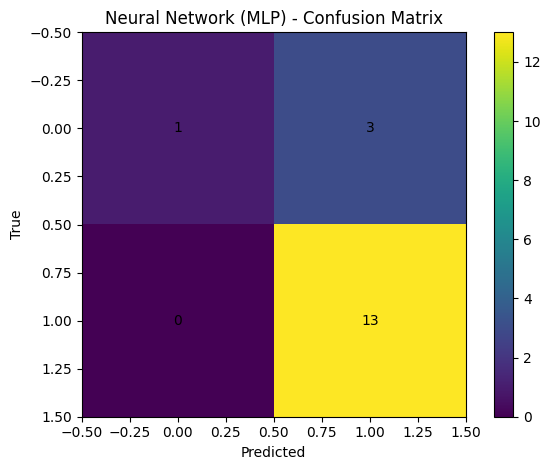


=== Model comparison ===
LogReg -> acc=0.4706, prec=0.7500, rec=0.4615, f1=0.5714
MLP    -> acc=0.8235, prec=0.8125, rec=1.0000, f1=0.8966
Best model based on F1: MLP


In [10]:
# =========================
# Cell 6: Neural Network (MLP)
# =========================

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=(64, 32), dropout=0.1):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

mlp_model = MLPClassifier(input_dim=input_dim, hidden_dims=(64, 32), dropout=0.1)

mlp_model = train_model(
    mlp_model,
    X_train_t, y_train_t,
    X_test_t,  y_test_t,
    lr=1e-3,
    epochs=500,
    batch_size=8,
    weight_decay=1e-4,
    verbose=True,
    model_name="NeuralNetwork"
)

mlp_model.eval()
with torch.no_grad():
    logits = mlp_model(X_test_t)
    probs  = torch.sigmoid(logits).cpu().numpy().flatten()
    y_pred_mlp = (probs >= 0.5).astype(int)

acc_mlp, prec_mlp, rec_mlp, f1_mlp, cm_mlp = classification_metrics(y_test, y_pred_mlp)

print("\n=== Neural Network (MLP) performance ===")
print("Accuracy :", acc_mlp)
print("Precision:", prec_mlp)
print("Recall   :", rec_mlp)
print("F1-score :", f1_mlp)
print("Confusion matrix:\n", cm_mlp)

plot_confusion_matrix(cm_mlp, title="Neural Network (MLP) - Confusion Matrix")

print("\n=== Model comparison ===")
print(f"LogReg -> acc={acc_lr:.4f}, prec={prec_lr:.4f}, rec={rec_lr:.4f}, f1={f1_lr:.4f}")
print(f"MLP    -> acc={acc_mlp:.4f}, prec={prec_mlp:.4f}, rec={rec_mlp:.4f}, f1={f1_mlp:.4f}")
best_model = "MLP" if f1_mlp >= f1_lr else "Logistic Regression"
print("Best model based on F1:", best_model)


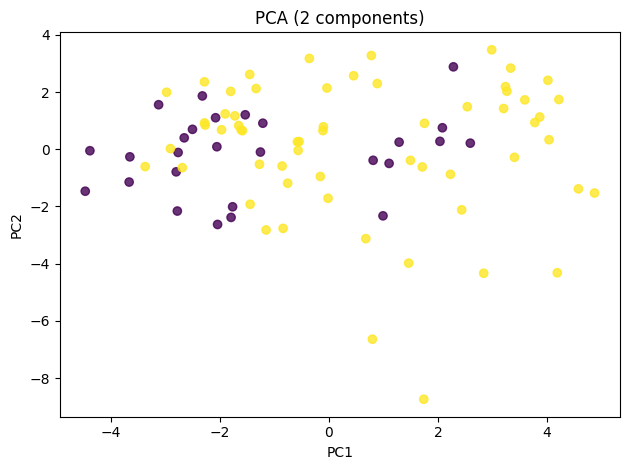

PCA explained variance ratio: [0.06908436 0.05252964]


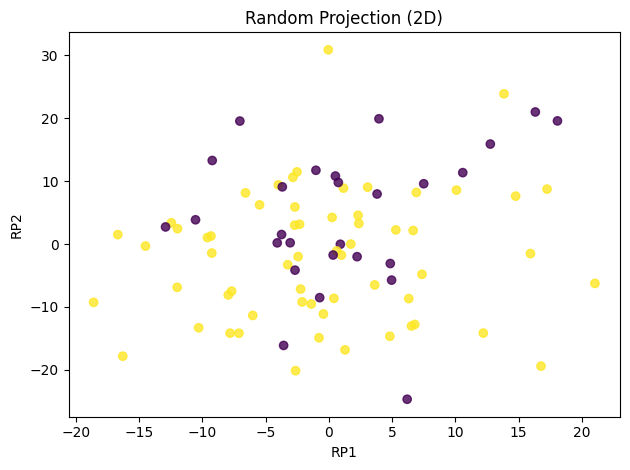

Perplexity value 29 is too high. Using perplexity 28.67 instead


Running t-SNE (openTSNE)...


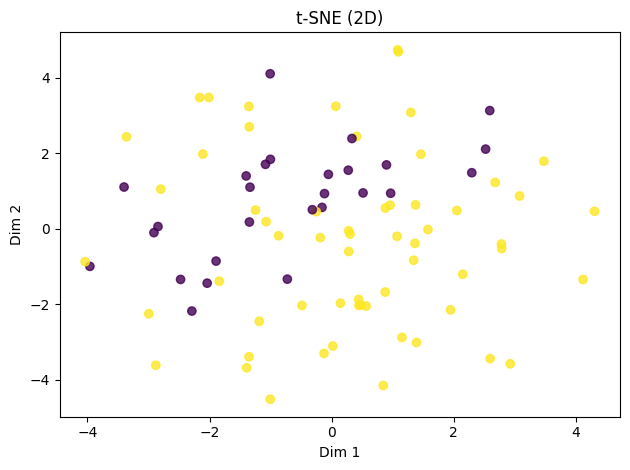

In [14]:
# =========================
# Cell 7: Dimensionality reduction (PCA, Random Projection, t-SNE/UMAP)
# =========================

# ----- PCA from scratch -----
def pca_from_scratch(X, n_components=2):
    # X should be (n_samples, n_features)
    Xc = X - X.mean(axis=0)
    cov = np.dot(Xc.T, Xc) / (Xc.shape[0] - 1)
    eigvals, eigvecs = np.linalg.eigh(cov)
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    comps = eigvecs[:, :n_components]
    X_pca = np.dot(Xc, comps)
    var_ratio = eigvals[:n_components] / eigvals.sum()
    return X_pca, var_ratio

# Run PCA
X_pca, pca_var = pca_from_scratch(X_scaled, n_components=2)

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, alpha=0.8)
plt.title("PCA (2 components)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

print("PCA explained variance ratio:", pca_var)


# ----- Random Projection (simple linear DR) -----
def random_projection(X, n_components=2, random_state=42):
    """
    Simple random linear projection:
    X_proj = X @ W, where W has random normal entries.
    Used as a very simple baseline for dimensionality reduction.
    """
    rng = np.random.RandomState(random_state)
    W = rng.normal(size=(X.shape[1], n_components))  # (n_features, n_components)
    X_rp = np.dot(X, W)
    return X_rp

X_rp = random_projection(X_scaled, n_components=2, random_state=RANDOM_STATE)

plt.figure()
plt.scatter(X_rp[:, 0], X_rp[:, 1], c=y, alpha=0.8)
plt.title("Random Projection (2D)")
plt.xlabel("RP1")
plt.ylabel("RP2")
plt.tight_layout()
plt.show()


# ----- t-SNE or UMAP (if installed) -----
if TSNE_AVAILABLE:
    print("Running t-SNE (openTSNE)...")
    tsne = TSNE(
        n_components=2,
        learning_rate="auto",
        initialization="random",
        random_state=RANDOM_STATE,
        perplexity=min(30, max(5, X_scaled.shape[0] // 3))
    )
    X_tsne = np.asarray(tsne.fit(X_scaled))
    plt.figure()
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, alpha=0.8)
    plt.title("t-SNE (2D)")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.tight_layout()
    plt.show()

elif UMAP_AVAILABLE:
    print("Running UMAP...")
    reducer = umap.UMAP(
        n_components=2,
        random_state=RANDOM_STATE,
        n_neighbors=10,
        min_dist=0.1
    )
    X_umap = reducer.fit_transform(X_scaled)
    plt.figure()
    plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, alpha=0.8)
    plt.title("UMAP (2D)")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.tight_layout()
    plt.show()

else:
    print("No openTSNE or UMAP installed. Install one for non-linear DR:")
    print("  pip install openTSNE")
    print("or")
    print("  pip install umap-learn")


Training XGBoost classifier for feature importance...


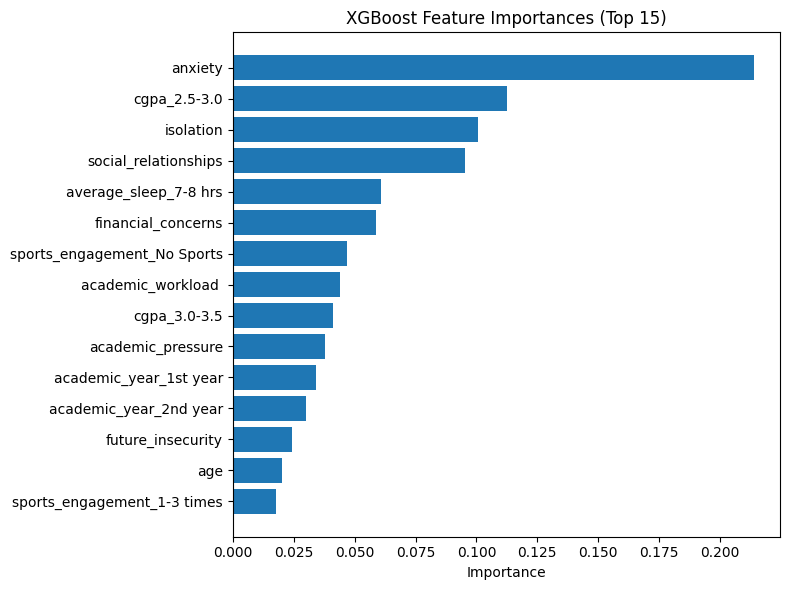


Top features by importance:
anxiety: 0.2139
cgpa_2.5-3.0: 0.1126
isolation: 0.1007
social_relationships: 0.0952
average_sleep_7-8 hrs: 0.0607
financial_concerns: 0.0589
sports_engagement_No Sports: 0.0469
academic_workload : 0.0440
cgpa_3.0-3.5: 0.0410
academic_pressure: 0.0379
academic_year_1st year: 0.0340
academic_year_2nd year: 0.0300
future_insecurity: 0.0243
age: 0.0202
sports_engagement_1-3 times: 0.0177

Running SHAP TreeExplainer...


C:\Users\sishi\AppData\Local\Temp\ipykernel_1468\1099458018.py:41: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train, feature_names=feature_names, show=True)


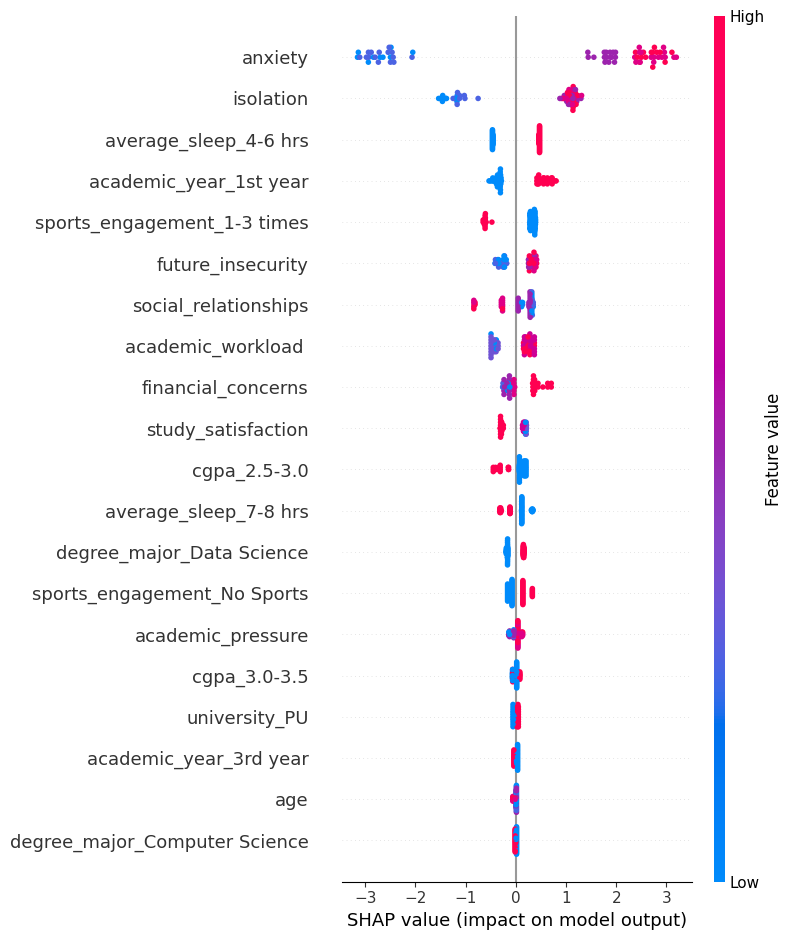

In [15]:
# =========================
# Cell 8: Feature importance (XGBoost + SHAP)
# =========================

if XGBOOST_AVAILABLE:
    print("Training XGBoost classifier for feature importance...")
    xgb_model = xgb.XGBClassifier(
        max_depth=4,
        learning_rate=0.1,
        n_estimators=200,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        objective="binary:logistic",
        random_state=RANDOM_STATE,
        eval_metric="logloss"
    )
    xgb_model.fit(X_train, y_train)

    importances = xgb_model.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    top_k = min(15, len(feature_names))
    top_idx = sorted_idx[:top_k]

    plt.figure(figsize=(8, 6))
    plt.barh(range(len(top_idx)), importances[top_idx][::-1])
    plt.yticks(range(len(top_idx)), [feature_names[i] for i in top_idx][::-1])
    plt.title("XGBoost Feature Importances (Top 15)")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

    print("\nTop features by importance:")
    for i in top_idx:
        print(f"{feature_names[i]}: {importances[i]:.4f}")

    if SHAP_AVAILABLE:
        print("\nRunning SHAP TreeExplainer...")
        explainer = shap.TreeExplainer(xgb_model)
        shap_values = explainer.shap_values(X_train)
        shap.summary_plot(shap_values, X_train, feature_names=feature_names, show=True)
    else:
        print("SHAP not installed. Install with: pip install shap")
else:
    print("XGBoost not installed. Install with: pip install xgboost")
